# Notes

**Hard Constraint:**  
- Each delivery locaiton must be visited exactly once
- Total **demand** of each vehicle route must not exceed its maximum **capacity**

**Self Cosntraint:**  
- Minimize cost required to meet all demands

**Assumption:**  
- Vehicles start and end their routes at the same depot location
- Each vehicle only travels one round trip (depart from depot and back to the depot)
- There is no limit on the number of vehicles.
- Travel times between any 2 locations are the same in both directions
- Deliveries can be made at any time, no time windows for deliveries
- Vehicle travel distance is calculated using Euclidian distance formula.

**Sample Output:**  
Vehicle 1 (Type A):  
Round Trip Distance: 41.861 km, Cost: RM 50.23, Demand: 22  
Depot -> C2 (9.072 km) -> C6 (1.834 km) -> C8 (19.343 km) -> Depot (11.612 km)  

Vehicle 2 (Type B):
...

# Implementation

In [1]:
# id with 0 = depot
nodes = [
    { 'id': 0, 'latitude': 4.4184, 'longitude': 114.0932, 'demand': 0 },
    { 'id': 1, 'latitude': 4.3555, 'longitude': 113.9777, 'demand': 5 },
    { 'id': 2, 'latitude': 4.3976, 'longitude': 114.0049, 'demand': 8 },
    { 'id': 3, 'latitude': 4.3163, 'longitude': 114.0764, 'demand': 3 },
    { 'id': 4, 'latitude': 4.3184, 'longitude': 113.9932, 'demand': 6 },
    { 'id': 5, 'latitude': 4.4024, 'longitude': 113.9932, 'demand': 5 },
    { 'id': 6, 'latitude': 4.4142, 'longitude': 113.9896, 'demand': 8 },
    { 'id': 7, 'latitude': 4.4804, 'longitude': 114.0127, 'demand': 3 },
    { 'id': 8, 'latitude': 4.3818, 'longitude': 114.0734, 'demand': 6 },
    { 'id': 9, 'latitude': 4.4935, 'longitude': 114.2034, 'demand': 5 },
    { 'id': 10, 'latitude': 4.4932, 'longitude': 114.1322, 'demand': 8 },
]

vehicles = [
    { 'vehicle': 'A', 'capacity': 25, 'cost': 1.2 },
    { 'vehicle': 'B', 'capacity': 30, 'cost': 1.5 }
]

In [55]:
import math
import networkx as nx
import matplotlib.pyplot as plt

class Node:
  def __init__(self, id, latitude, longitude, demand):
    self.id = id
    self.latitude = latitude
    self.longitude = longitude
    self.demand = demand
    
  def calculate_distance(self, node):
    return 100 * math.sqrt(
      math.pow(node.longitude - self.longitude, 2) +
      math.pow(node.latitude - self.latitude, 2)
    )
  
class Vehicle:
  def __init__(self, vehicle, capacity, cost):
    self.vehicle = vehicle
    self.capacity = capacity
    self.cost = cost

class Path:
  def __init__(self): 
    self.nodes = []
  
  def add_node(self, node):
    self.nodes.append(node)

  def calculate_total_distance(self):
    total_distance = 0
    for i in range(len(self.nodes) - 1):
      total_distance += self.nodes[i].calculate_distance(self.nodes[i+1])

    return total_distance
  
  def print_path(self):
    for index, node in enumerate(self.nodes):
      if index != len(self.nodes) - 1:
        print(node.id, end=' -> ')
      else:
        print(node.id)
    print()

  def print_output(self):
    pass

  def plot_path(self, figsize=(14, 8)):
    """
      Visualize the path
      Placement of label is not consistent 
    """
    G = nx.DiGraph()
    edges = []
    for index in range(len(self.nodes) - 1):
      edges.append(
        (
          self.nodes[index].id, 
          self.nodes[index+1].id, 
          {'weight': round(self.nodes[index].calculate_distance(self.nodes[index+1]), 4)} # weight between 2 nodes
        )
      )

    G.add_edges_from(edges)
    plt.figure(figsize=figsize)
    pos = nx.circular_layout(G)
    nx.draw(G, with_labels=True)
    edge_weight = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
    plt.show()

In [83]:
import numpy as np

def calculate_saving_heuristics(
    depot_node, 
    source_node,
    dst_node
):
  G = 2
  F = 0.3

  intermediate_result = source_node.calculate_distance(depot_node) + depot_node.calculate_distance(dst_node)
  saving_heuristic = intermediate_result - (G * source_node.calculate_distance(dst_node)) + (F * abs(intermediate_result))

  return saving_heuristic

def calculate_load_influence(
    current_capacity,
    maximum_capacity,
    demand
):
  return (current_capacity + demand) / maximum_capacity

def calculate_probs(
    pheromone,
    depot_node,
    source_node,
    dst_node,
    current_capacity,
    maximum_capacity,
):
  # calculate probs for 1 data point
  ALPHA = 1
  BETA = 1
  GAMMA = 1
  DELTA = 1

  inverse_distance = (1 / source_node.calculate_distance(dst_node)) * BETA
  pheromone_influence = pheromone * ALPHA
  saving_heuristic = calculate_saving_heuristics(depot_node, source_node, dst_node) * GAMMA
  load_influence = calculate_load_influence(current_capacity, maximum_capacity, dst_node.demand) * DELTA

  return inverse_distance * pheromone_influence * saving_heuristic * load_influence

def calculate_next_node(
    vertices,
    pheromone_matrix,
    visited_nodes,
    current_node,
    current_capacity,
    maximum_capacity,
):
  # compute probs and decide next node
  probabilities_nodes = []
  
  for index, node in enumerate(vertices):
    if index == 0 or visited_nodes[index]:
      probabilities_nodes.append(0.0) # skip depot and visited nodes

    else:
      # calculate probability
      prob = calculate_probs(
        pheromone_matrix[current_node][index],
        vertices[0],
        vertices[current_node],
        node,
        current_capacity,
        maximum_capacity
      )
      
      probabilities_nodes.append(prob)

  # select next node
  probabilities_nodes = np.array(probabilities_nodes)
  probabilities_nodes = probabilities_nodes / probabilities_nodes.sum()
  next_node = np.argmax(probabilities_nodes) 
  
  return next_node # index of next node

def aco(
    dataset, # nodes
    vehicle_used, # vehicle object
    n_iter, # number of iterations for the generation of solution
    n_ants, # number of ants within each iteration 
    evaporation_rate, # strength of evaporation on the pheromone
    pheromone_coefficient, 
):
  vertices = [Node(**node) for node in dataset]
  pheromone_matrix = np.ones((len(vertices), len(vertices)))
  best_solution_so_far = None

  current_iter = 0
  while current_iter < n_iter:
    solutions_found = []

    for _ in range(n_ants):
      visited_nodes = [False] * len(vertices)
      visited_nodes[0] = True # depot is source node
      current_node = 0
      current_capacity = 0
      x = np.zeros((len(vertices), len(vertices))) # matrix to determine whether the edge exists between 2 nodes

      # initiate path
      path = Path()
      path.add_node(vertices[0]) # add depot

      while not all(visited_nodes):
        # if havent visit all nodes yet, then continue this iteration

        # decide next node
        next_node = calculate_next_node(
          vertices,
          pheromone_matrix,
          visited_nodes,
          current_node,
          current_capacity,
          vehicle_used.capacity # maximum capacity
        )

        if current_capacity + vertices[next_node].demand > vehicle_used.capacity:
          # return to depot if cannot proceed to next node due to capacity
          next_node = 0
          current_capacity = 0 # free all load at the depot

        else:
          # visit the next node
          visited_nodes[next_node] = True
          x[current_node][next_node] = 1 # update that there's edge between 2 nodes
          current_capacity += vertices[next_node].demand

        current_node = next_node # update current position
        path.add_node(vertices[next_node])

      current_node = 0 # return to depot
      path.add_node(vertices[current_node]) # add last node in the path
      solutions_found.append(path)
    
    # evaporate pheromone trails 
    pheromone_matrix = pheromone_matrix * evaporation_rate

    # calculate the distance for each solution found
    distances = [solution.calculate_total_distance() for solution in solutions_found]
    minimum_path_index = np.argmin(distances)

    # update pheromone trails
    if best_solution_so_far is None:
      # if there's no best sol yet (prob first iter), use the min in current
      best_solution_distance = distances[minimum_path_index]

    else:
      # if there's best sol alr
      best_solution_distance = best_solution_so_far.calculate_total_distance()

    # update the pheromone trails 
    pheromone_matrix = (pheromone_matrix + x) * (pheromone_coefficient * (best_solution_distance / distances[minimum_path_index]))

    # save the best solution on global 
    if best_solution_so_far is None:
      best_solution_so_far = solutions_found[minimum_path_index]

    elif best_solution_so_far.calculate_total_distance() > distances[minimum_path_index]:
      # if have lower distance path then mark that as the best solution
      best_solution_so_far = solutions_found[minimum_path_index]

    current_iter += 1
    
  return best_solution_so_far


In [84]:
# vehicle A 
vehicle_used = Vehicle(**vehicles[0])
best_path_A = aco(
    nodes,
    vehicle_used, # vehicle A
    5,
    5,
    0.2, # evaporation rate
    0.2, # pheromone coefficient
)

In [85]:
best_path_A.print_path()

0 -> 2 -> 5 -> 6 -> 0 -> 10 -> 8 -> 3 -> 4 -> 0 -> 1 -> 9 -> 7 -> 0



In [86]:
best_path_A.calculate_total_distance()

140.87444698860025

In [87]:
# vehicle B
vehicle_used = Vehicle(**vehicles[1])
best_path_B = aco(
    nodes,
    vehicle_used,
    5,
    5,
    0.2, # evaporation rate
    0.2, # pheromone coefficient
)

In [88]:
best_path_B.print_path()

0 -> 10 -> 8 -> 3 -> 4 -> 1 -> 0 -> 2 -> 5 -> 6 -> 7 -> 9 -> 0



In [89]:
best_path_B.calculate_total_distance()

104.11629904668148

# Visualization

In [63]:
best_path_A.print_path()

0 -> 2 -> 5 -> 6 -> 0 -> 10 -> 8 -> 3 -> 4 -> 0 -> 1 -> 9 -> 7 -> 0



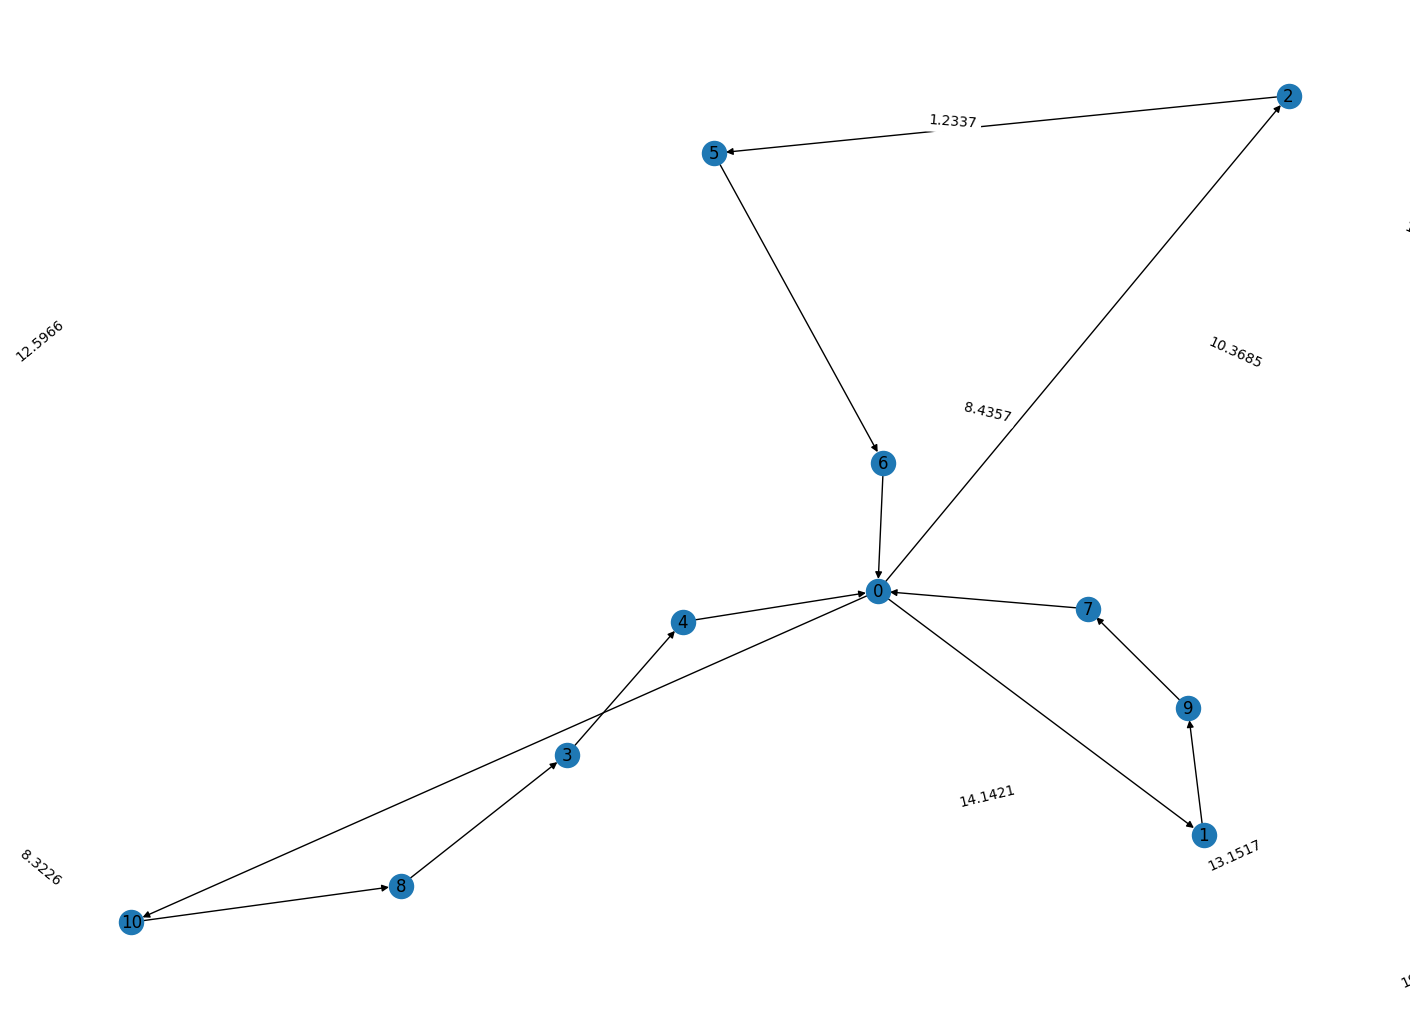

In [64]:
best_path_A.plot_path(figsize=(14, 10))

# References
1. https://www.researchgate.net/publication/228557657_Metaheuristics_for_Vehicle_Routing_Problems_with_Loading_Constraints_for_Wood_Products
2. https://github.com/afurculita/VehicleRoutingProblem/blob/master/src/ro/uaic/info/acs/VrpAcsSolver.java
3. https://github.com/pkonowrocki/CVRP_ACO